# Aligning HST images to an absolute reference catalog
***

<div class="alert-danger">Note: The notebook in this repository 'Initializtion.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, 'DrizzlePac' or 'Astroquery'.</div>

<div class="alert-warning">Note: This notebook is based on WFC3 ISR 2017-19: <a href="http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2017-19.pdf">Aligning HST Images to Gaia: a Faster Mosaicking Workflow</a> and contains a subset of the information/code found in <a href="https://github.com/spacetelescope/gaia_alignment">the repository here</a>.  For more information, see the notebook in that repository titled 'Gaia_alignment.ipynb'.</div>

## Introduction

The alignment of HST exposures is a critical step in image stacking/combination performed by software such as `AstroDrizzle`.  Generally, a relative alignment is performed that aligns one image (or multiple images) to another image which is designated as the reference image.  This makes it so the images are aligned to each other, but the pointing error of the observatory can still cause the images to have incorrect absolute astrometry.

When absolute astrometry is desired, the images can be aligned to an external catalog that is known to be on an absolute frame.  In this example, we will provide a workflow to query catalogs such as SDSS and Gaia via the astroquery package, and then align the images to that catalog via TweakReg.

For more information about TweakReg, see the other notebooks in this repository or the __[TweakReg Documentation](https://drizzlepac.readthedocs.io/en/deployment/tweakreg.html)__.

For more information on Astroquery, see the other notebooks in this repository or the __[Astroquery Documentation](https://astroquery.readthedocs.io/en/latest/)__.

In [181]:
import astropy.units as u
import glob
import numpy as np
import matplotlib.pyplot as plt
import os

from astropy.io import fits
from astropy.table import Table
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astroquery.mast import Observations
from astroquery.sdss import SDSS

#from ccdproc import ImageFileCollection
from IPython.display import Image

from drizzlepac import tweakreg
from drizzlepac import astrodrizzle

# 1. Set up the data

In [182]:
from utils import header_utils as hutils

In [183]:
from pathlib import Path
Path(hutils.__file__).parent / "../../data/tables/"

PosixPath('/user/jaguilar/tr14/code/utils/../../data/tables')

In [184]:
from importlib import reload
reload(hutils)

<module 'utils.header_utils' from '/user/jaguilar/tr14/code/utils/header_utils.py'>

In [185]:
reload(hutils)
prihdrs = hutils.load_headers('pri')
scihdrs = hutils.load_headers('sci')

In [186]:
hutils.__file__

'/user/jaguilar/tr14/code/utils/header_utils.py'

In [187]:
import pandas as pd

In [188]:
# TH.print_columns(prihdrs)
gb_filter = prihdrs.groupby('filter')
gb_filter

In [189]:
hutils.print_columns(prihdrs)

ang_side
aperture
asn_id
asn_mtyp
asn_tab
atodgna
atodgnb
atodgnc
atodgnd
atodtab
badinpdq
biacfile
biasfile
biasleva
biaslevb
biaslevc
biaslevd
bitpix
blevcorr
bpixtab
cal_ver
ccdamp
ccdgain
ccdofsab
ccdofscd
ccdtab
comptab
crcorr
crds_ctx
crds_ver
crmask
crradius
crrejtab
crsigmas
crthresh
csmid
csys_ver
d2imfile
darkcorr
darkfile
date
date-obs
dec_targ
detector
dfltfile
dgeofile
dirimage
distname
dqicorr
drizcorr
drkcfile
dwell_ln
dwell_tm
equinox
expend
expflag
expstart
exptime
extend
fgslock
filename
filetype
filter
flatcorr
flshfile
graphtab
gyromode
idctab
imagetyp
imphttab
initgues
instrume
lfltfile
linenum
mdriztab
meanexp
moonangl
mtflag
naxis
nextend
nlincorr
nlinfile
no_lines
npolfile
nrptexp
nsamp
obsmode
obstype
opus_ver
origin
oscntab
p1_angle
p1_centr
p1_frame
p1_lspac
p1_npts
p1_orint
p1_pspac
p1_purps
p1_shape
pa_v3
pattern1
pattstep
pctetab
pfltfile
photbw
photcorr
photflam
photfnu
photmode
photplam
photzpt
postarg1
postarg2
pr_inv_f
pr_inv_l
pr_inv_m
primesi
proctim

In [190]:
# re-download the data from MAST, following the example
proposids = prihdrs['proposid'].unique()
filters = prihdrs['filter'].unique()
prihdrs.query(f"proposid == {proposids[0]}")

,simple,bitpix,naxis,extend,origin,date,nextend,filename,filetype,telescop,...,flshfile,pctetab,snkcfile,upwcsver,pywcsver,npolfile,idctab,d2imfile,sipname,distname
0,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,13,icct01i5q_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct01i5q_w3m18525i,icct01i5q_w3m18525i-NOMODEL-NOMODEL
3,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,13,icct02jxq_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct02jxq_w3m18525i,icct02jxq_w3m18525i-NOMODEL-NOMODEL
4,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,14,icct04omq_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct04omq_w3m18525i,icct04omq_w3m18525i-NOMODEL-NOMODEL
5,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,13,icct04p1q_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct04p1q_w3m18525i,icct04p1q_w3m18525i-NOMODEL-NOMODEL
6,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,14,icct02jiq_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct02jiq_w3m18525i,icct02jiq_w3m18525i-NOMODEL-NOMODEL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,13,icct04oxq_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct04oxq_w3m18525i,icct04oxq_w3m18525i-NOMODEL-NOMODEL
178,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,13,icct04p0q_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct04p0q_w3m18525i,icct04p0q_w3m18525i-NOMODEL-NOMODEL
179,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,13,icct01iaq_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct01iaq_w3m18525i,icct01iaq_w3m18525i-NOMODEL-NOMODEL
180,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,13,icct04p7q_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct04p7q_w3m18525i,icct04p7q_w3m18525i-NOMODEL-NOMODEL


### Inspect the image header

The cell below shows how to query information from the image header using `ImageFileCollection` in `ccdproc`. 
We see that the 1st exposure is 30 seconds and the 2nd and 3rd exposures are 360 seconds. The 3rd exposure is dithered by ~82" in the Y-direction which is approximately the width of one UVIS chip. 

# 2. Querying catalogs

Now that we have the images, we will download the reference catalogs from both SDSS and Gaia using `astroquery`.

### 2a. Identify Coordinates
We will first create a SkyCoord Object to point astroquery to where we are looking on the sky.  Since our example uses data from NGC 6791, we will use the `ra_targ` and `dec_targ` keywords from the first image to get the coordinates of the object.

In [191]:
RA, Dec = prihdrs[['ra_targ','dec_targ']].mean()

### 2b. SDSS Query
We now give those values to an astropy `SkyCoord` object, which we will pass to the SDSS.  Additionally, we use an astropy `Quantity` object to create a radius for the SDSS query.  We set the radius to 6 arcminutes to comfortably cover the area of our images. For reference UVIS detector field of view is ~2.7'x2.7' and a y-dither of 82" covers a total area on the sky of ~2.7'x4.1'.

In [192]:
coord = SkyCoord(ra=RA, dec=Dec, unit=(u.deg, u.deg))
radius = Quantity(6., u.arcmin)

Then we only need to perform the query via the `SDSS.query_region` method of `astroquery.sdss`. The `spectro=False` keyword argument means we want to exclude spectroscopic objects, as we are looking for objects to match with an image.  

In the fields parameter, we specify a list of fields we want returned by the query.  In this case we only need the position, and maybe a magnitude 'g' if we want to cut very dim and/or bright objects out of the catalog, as those are likely measured poorly. Details on selecting objects by magnitude may be found in the original ['Gaia_alignment' notebook](https://github.com/spacetelescope/gaia_alignment).  Many other fields are available in the SDSS query and are [documented here](http://cas.sdss.org/dr7/en/help/browser/description.asp?n=PhotoObj&t=V).

### 2c. Gaia Query
Similarly to SDSS, we can query Gaia catalogs for our target via `astroquery.gaia`.  We can use the same `coord` and  `radius` from the SDSS query.

In [193]:
# JA: I already have the file I need
# gaia_query = Gaia.query_object_async(coordinate=coord, radius=radius)
# gaia_query

This query has returned very large number of columns. We want to pare down the catalog to make it easier to use with `TweakReg`.  
We can select only the useful columns via:

In [194]:
# reduced_query = gaia_query['ra', 'dec', 'phot_g_mean_mag']
# reduced_query

Then we write this catalog to an ascii file for use with `TweakReg`.

In [195]:
# reduced_query.write('../data/align_catalog/gaia.cat', format='ascii.commented_header')

## 3. Running TweakReg
With the catalogs downloaded and the headers populated, we simply need to run TweakReg with each catalog passed into the `refcat` parameter. The steps below compare the astrometric residuals obtained from aligning to each `refcat`. In each test case, we set `updatehdr` to False until we are satisfied with the alignment by inspecting both the shift file and the astrometric residual plots.

As we can see, the RMS is fairly large at about 0.5 pixels, which is not a great fit. This is likely because the SDSS astrometric precision is not high enough to get good HST alignment. One approach would be to align the first image to SDSS and then align the remaining HST images to one another. This would improve both the absolute and relative alignment of the individual frames.

### 3b. Gaia Alignment

In [196]:
from pathlib import Path
# [(Path("../data/tr14/") / i).as_posix() 
#  for i in gb_filter.get_group(filters[0])['FILENAME']]

In [197]:
from utils import table_utils as tutils


In [198]:
list_of_images = [(Path("../data/my_data/") / i).as_posix() 
                  for i in tutils.get_value(prihdrs, 'subarray', False, 'filename')]
len(list_of_images)

54

In [199]:
import matplotlib as mpl

In [200]:
# hdulist = fits.open(list_of_images[0])
# data = hdulist[1].data
# fig, ax = plt.subplots(1,1)
# ax.imshow(data, norm=mpl.colors.LogNorm())
# hdulist.close()

Setting up logfile :  tweakreg.log
TweakReg Version 1.4.7(18-April-2018) started at: 01:26:15.175 (03/05/2020) 

Version Information
--------------------
Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
numpy Version -> 1.18.1 
astropy Version -> 4.0.1.post1 
stwcs Version -> 1.5.3 

Finding shifts for: 
    /user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits

===  Source finding for image '/user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits':
  #  Source finding for '/user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits', EXT=('SCI', 1) started at: 01:26:15.66 (03/05/2020)
     Found 63 objects.
===  FINAL number of objects in image '/user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits': 63


Performing alignment in the projection plane defined by the WCS
derived from '/user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits'


Performing fit for: /user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits

Matching so

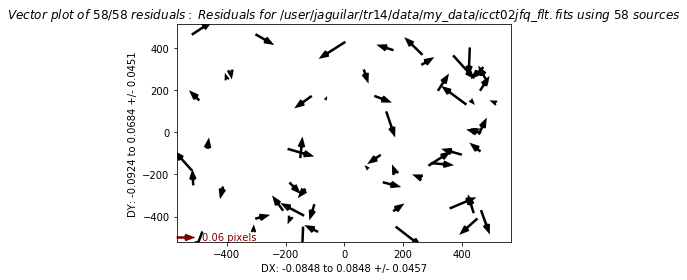

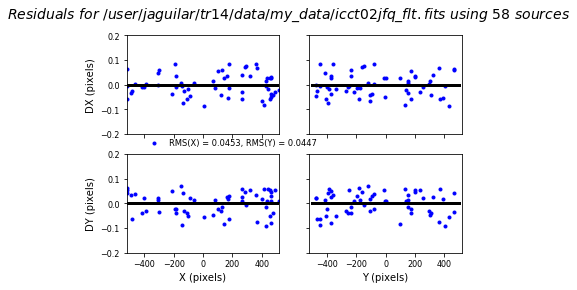

In [201]:
refcat = '../data/align_catalog/gaia.cat'
cw = 3.5  # Set to two times the FWHM of the PSF.
wcsname = 'Gaia'  # Specify the WCS name for this alignment
ff = list_of_images[0]
thresh = 500.
tweakreg.TweakReg(ff,#'*flc.fits',  # Pass input images
                  updatehdr=False,  # update header with new WCS solution
                  imagefindcfg={'threshold':thresh,'conv_width':cw},  # Detection parameters, threshold varies for different data
                  refcat=refcat,  # Use user supplied catalog (Gaia)
                  interactive=False,
                  see2dplot=False,
                  shiftfile=True,  # Save out shift file (so we can look at shifts later)
                  outshifts='Gaia_shifts.txt',  # name of the shift file
                  wcsname=wcsname,  # Give our WCS a new name
                  reusename=True,
                  sigma=2.3,
                  ylimit=0.2,
                  fitgeometry='general')  # Use the 6 parameter fit
#%pdb 0
#%debug -b /Users/jaguilar/miniconda3/envs/orbitize/lib/python3.6/site-packages/drizzlepac/imgclasses.py:1604
# reload(tweakreg)
# tweakreg.TweakReg(list_of_images,
#                   refcat=refcat)

We can similarly look at the shift file from alignment to the Gaia catalog:

In [202]:
for line in open('Gaia_shifts.txt').readlines():
    print(line)

# frame: output

# refimage: shifts_wcs.fits[wcs]

# form: delta

# units: pixels

/user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits    -0.239274  -0.420785    0.013617     1.000080   0.045282  0.044699



In [203]:
# Astrometric residual plots
# Image(filename='residuals_ibwb01xqq_flc.png',width=500, height=300)

In [204]:
# Image(filename='residuals_ibwb01xrq_flc.png',width=500, height=300)

In [26]:
# Image(filename='residuals_ibwb01xxq_flc.png',width=500, height=300)

As expected, the Gaia catalog does quite a bit better, with rms residuals less tha 0.05 pixels.  

To apply these transformations to the image, we simply need to run TweakReg the same as before, but set the parameter `updatehdr` equal to `True`:

Setting up logfile :  tweakreg.log
TweakReg Version 1.4.7(18-April-2018) started at: 01:26:34.79 (03/05/2020) 

Version Information
--------------------
Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
numpy Version -> 1.18.1 
astropy Version -> 4.0.1.post1 
stwcs Version -> 1.5.3 

Finding shifts for: 
    /user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits

===  Source finding for image '/user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits':
  #  Source finding for '/user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits', EXT=('SCI', 1) started at: 01:26:35.011 (03/05/2020)
     Found 63 objects.
===  FINAL number of objects in image '/user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits': 63


Performing alignment in the projection plane defined by the WCS
derived from '/user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits'


Performing fit for: /user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits

Matching so

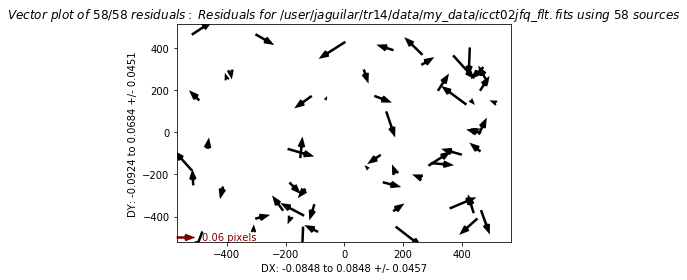

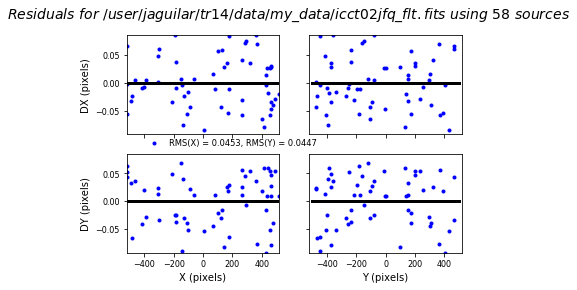

In [205]:
tweakreg.TweakReg(ff,  # Pass input images
                  updatehdr=True,  # update header with new WCS solution
                  imagefindcfg={'threshold': thresh, 'conv_width': cw},  # Detection parameters, threshold varies for different data
                  refcat=refcat,  # Use user supplied catalog (Gaia)
                  interactive=False,
                  see2dplot=False,
                  shiftfile=True,  # Save out shift file (so we can look at shifts later)
                  outshifts='Gaia_shifts.txt',  # name of the shift file
                  wcsname=wcsname,  # Give our WCS a new name
                  reusename=True,
                  sigma=2.3,
                  fitgeometry='general',  # Use the 6 parameter fit
                  clean=False,
                 )

In [206]:
# Look at the catalog

In [210]:
cat_file = Path(f"./{Path(ff[0]).name.split('.')[0]}_catalog_fit.match")

In [211]:
cat_file.exists()

False

In [212]:
from utils import cat_utils
reload(cat_utils)

<module 'utils.cat_utils' from '/user/jaguilar/tr14/code/utils/cat_utils.py'>

In [213]:
cat_utils.cat_fit_columns

['x_ref',
 'y_ref',
 'x_input',
 'y_input',
 'x_fit',
 'y_fit',
 'x_resid',
 'y_resid',
 'x_orig_ref',
 'y_orig_ref',
 'x_orig_input',
 'y_orig_input',
 'ref_id',
 'input_id',
 'input_extver_id',
 'ra',
 'dec',
 'ref_source']

In [214]:
import pandas as pd

In [215]:
reload(cat_utils)

<module 'utils.cat_utils' from '/user/jaguilar/tr14/code/utils/cat_utils.py'>

In [216]:
master_catalog = pd.concat([cat_utils.catalog2pandas(f) 
                           for f in glob.glob("*catalog_fit.match")])
# make a unique index for each point source
master_catalog = master_catalog.reset_index(drop=True).reset_index()
master_catalog.rename(columns={'index':'sourceid'}, inplace=True)

/Users/jaguilar/miniconda3/envs/orbitize/lib/python3.6/site-packages/pandas/io/parsers.py:2420: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/jaguilar/miniconda3/envs/orbitize/lib/python3.6/site-packages/pandas/io/parsers.py:2423: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


In [217]:
master_catalog.to_csv("../data/tables/master_fullframe_source_catalog.csv")

In [218]:
files = master_catalog['file_id'].unique()

In [219]:
files

array(['icct02jfq'], dtype=object)

In [220]:
ff

'../data/my_data/icct02jfq_flt.fits'

In [221]:
# example file
ff = files[0]
sub_catalog = master_catalog.query(f"file_id == '{ff}'")

In [222]:
hdulist = fits.open(glob.glob(f"../data/my_data/{ff}*fits")[0])
data = hdulist[1].data
hdulist.close()

./figs/tweakreg_demo_500.0.png


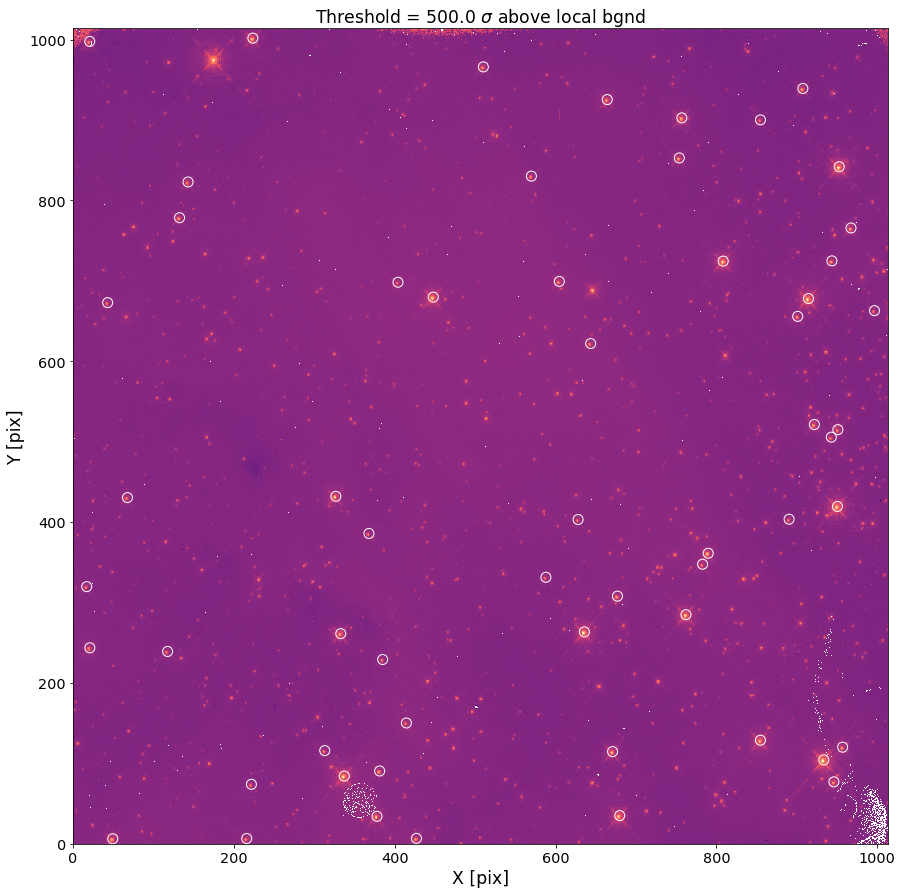

In [223]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.imshow(data, origin='lower', norm=mpl.colors.LogNorm(), cmap=mpl.cm.magma)
ax.set_title(rf"Threshold = {thresh} $\sigma$ above local bgnd", size='xx-large')
ax.set_xlabel("X [pix]", size='xx-large')
ax.set_ylabel("Y [pix]", size='xx-large')
ax.tick_params(labelsize='x-large')
ax.scatter(sub_catalog['x_orig_input'], 
           sub_catalog['y_orig_input'], 
           marker='o', ec='w', fc='none', s=100)
ax.set_xlim(0, data.shape[1])
ax.set_ylim(0, data.shape[0])
# for i, row in sub_catalog.iterrows():
#     s = '{0:0.2f}, {1:0.2f}'.format(*row[['ra','dec']])
#     ax.annotate(s, row[['x_orig_input','y_orig_input']],
#                 fontsize='large',
#                 verticalalignment='top', horizontalalignment='center')
fname = f"./figs/tweakreg_demo_{thresh}.png"
print(fname)
if False:
    fig.savefig(fname, bbox_inches='tight')

In [224]:
sub_catalog['input_id'].unique().size

58

In [225]:
# Map data to RA and Dec

In [226]:
from drizzlepac import pixtosky

In [227]:
from utils import shared_utils as sutils
filename = tutils.get_file_from_file_id(ff)
filename.exists()

True

In [232]:
hdulist = fits.open(filename)

In [233]:
data = hdulist[1].data
hdulist.close()

In [234]:
# from stwcs import distortion, wcsutil
# ind = np.indices(data.shape)
# inwcs = wcsutil.HSTWCS(filename.as_posix()+"[sci,1]")
# radec = inwcs.all_pix2world(np.array([ind[0].ravel(), ind[1].ravel()]).T,
#                             0)
# radec = np.reshape(radec.T, ind.shape)

In [235]:
reload(cat_utils)
radec = cat_utils.pix2sky(filename)
radec.shape

(2, 1014, 1014)

In [236]:
radec[0,0,0], radec[1,0,0]

(160.93357392035261, -59.590221067119124)

In [237]:
reload(cat_utils)
cat_utils.pix2sky(filename, x=0, y=0)

array([160.93357392, -59.59022107])

In [238]:
reload(cat_utils)
cat_utils.pix2sky(filename, x=np.array([0, 1, 2]), y=np.array([0, 1, 2])).shape

(2, 3)

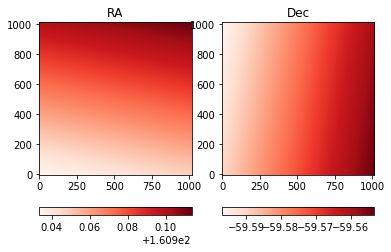

In [239]:
fig, axes = plt.subplots(1, 2)
ax = axes[0]
ax.set_title("RA")
imax = ax.imshow(radec[0], cmap = mpl.cm.Reds, origin='lower')
plt.colorbar(imax, ax=ax, orientation='horizontal')

ax = axes[1]
ax.set_title("Dec")
imax = ax.imshow(radec[1], cmap = mpl.cm.Reds, origin='lower')
plt.colorbar(imax, ax=ax, orientation='horizontal')


In [240]:
# OK, the next step is to ID some sources and find their RA and Dec

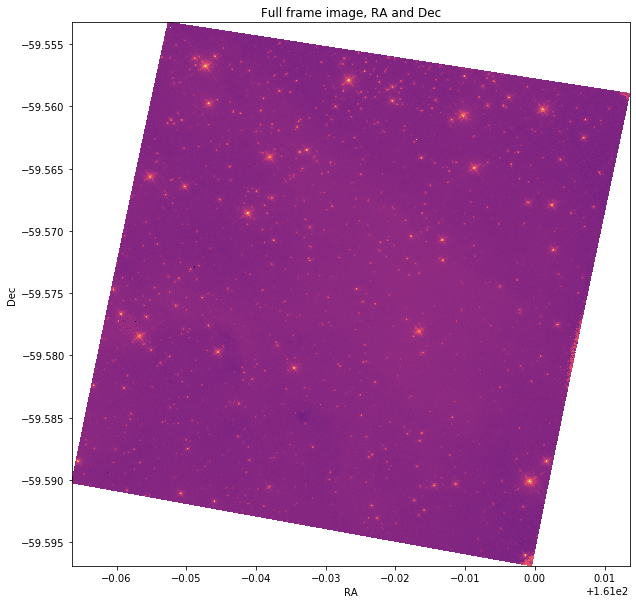

In [241]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Full frame image, RA and Dec")
ax.set_xlabel("RA")
ax.set_ylabel("Dec")
ax.pcolormesh(radec[0], radec[1], data, norm=mpl.colors.LogNorm(), cmap=mpl.cm.magma)

# Now find some point sources and overplot them

In [242]:
sources = pd.read_csv("../data/tables/dao_sources_icct02jfq.csv")

In [243]:
sources_radec = cat_utils.pix2sky(tutils.get_file_from_file_id(ff),
                                 x=sources['xcentroid'], y=sources['ycentroid'])

In [244]:
from astropy.visualization import SqrtStretch,  LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

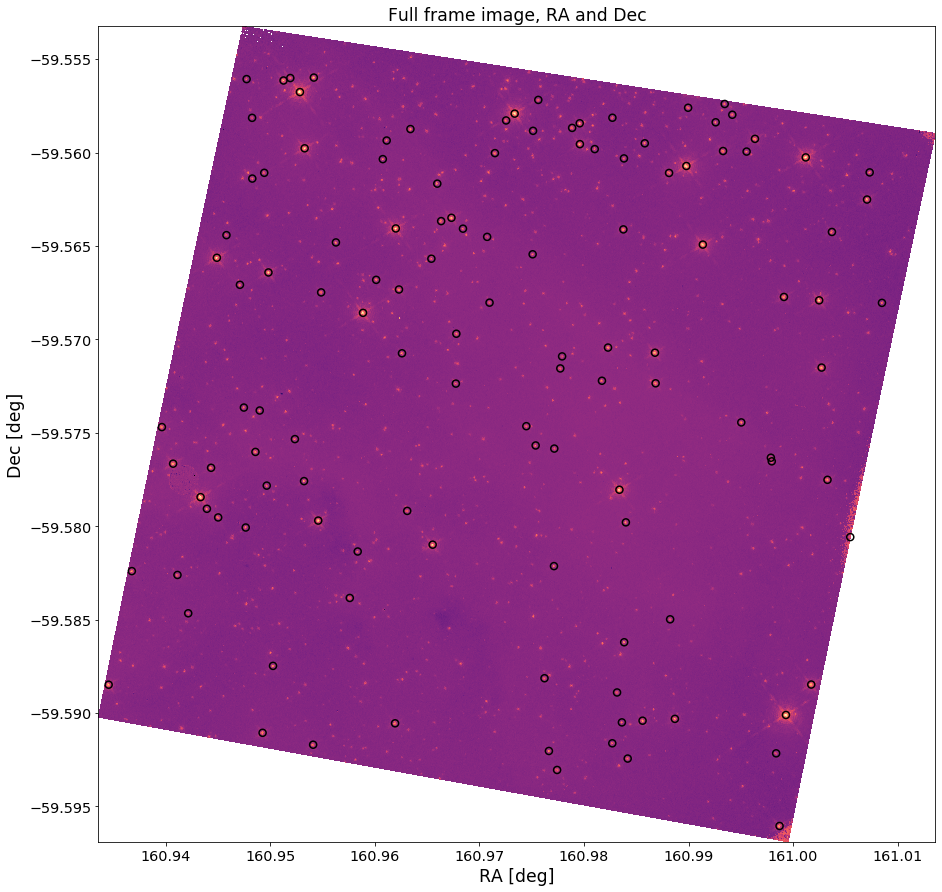

In [245]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.set_title("Full frame image, RA and Dec", size='xx-large')
ax.set_xlabel("RA [deg]", size='xx-large')
ax.set_ylabel("Dec [deg]", size='xx-large')
ax.tick_params(labelsize='x-large')
ax.ticklabel_format(useOffset=False)
ax.pcolormesh(radec[0], radec[1], data, norm=mpl.colors.LogNorm(), cmap=mpl.cm.magma)
ax.scatter(*sources_radec, fc='none', ec='k', s=50, lw=1.5)



./figs/tweakreg_demo_500.0.png


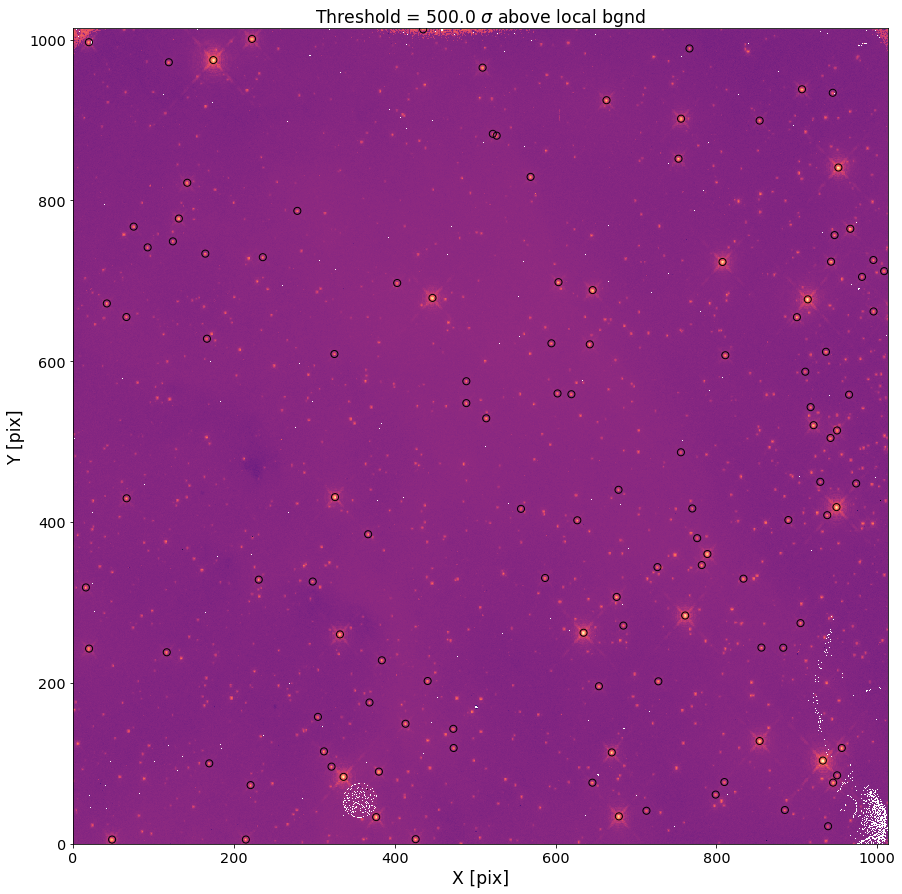

In [246]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.imshow(data, origin='lower', norm=mpl.colors.LogNorm(), cmap=mpl.cm.magma)
ax.set_title(rf"Threshold = {thresh} $\sigma$ above local bgnd", size='xx-large')
ax.set_xlabel("X [pix]", size='xx-large')
ax.set_ylabel("Y [pix]", size='xx-large')
ax.tick_params(labelsize='x-large')
ax.scatter(*sources[['xcentroid','ycentroid']].values.T,
           marker='o', ec='k', fc='none', s=50)
ax.set_xlim(0, data.shape[1])
ax.set_ylim(0, data.shape[0])
# for i, row in sub_catalog.iterrows():
#     s = '{0:0.2f}, {1:0.2f}'.format(*row[['ra','dec']])
#     ax.annotate(s, row[['x_orig_input','y_orig_input']],
#                 fontsize='large',
#                 verticalalignment='top', horizontalalignment='center')
fname = f"./figs/tweakreg_demo_{thresh}.png"
print(fname)
if False:
    fig.savefig(fname, bbox_inches='tight')